Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train path: /content/drive/MyDrive/datasets/Train_set.csv
Test  path: /content/drive/MyDrive/datasets/Test_set.csv
Train shape: (367767, 54)
Test  shape: (94946, 54)
Columns sample: ['household_ID', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)', 'w1_hh_member_count', 'w1_hh_avg_age', 'w1_hh_num_children', 'w1_hh_num_seniors', 'w1_hh_avg_hours_home', 'w1_hh_share_went_out_for_work', 'w1_num_fans', 'w1_fan_hours_day', 'w1_fan_hours_night', 'w1_num_lights', 'w1_light_total_wattage']
Columns to drop (not used as features):
['household_ID', 'DATE', 'TIME', 'timestamp', 'TOTAL_IMPORT (kWh)']

Number of feature columns: 48

Initial numeric cols (by dtype): 31
Initial categorical cols (by dtype): 17

Final numeric feature columns (31):
['w1_hh_member_count', 'w1_hh_avg_age', 'w1_hh_num_children', 'w1_hh_num_seniors', 'w1_hh_avg_hours_home', 'w1_hh_share_went_out_for_work', 'w

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 47.0min finished


Training done.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    4.1s finished



=== Test Performance ===
MAE : 0.3563
RMSE: 0.7145
R^2 : 0.5991


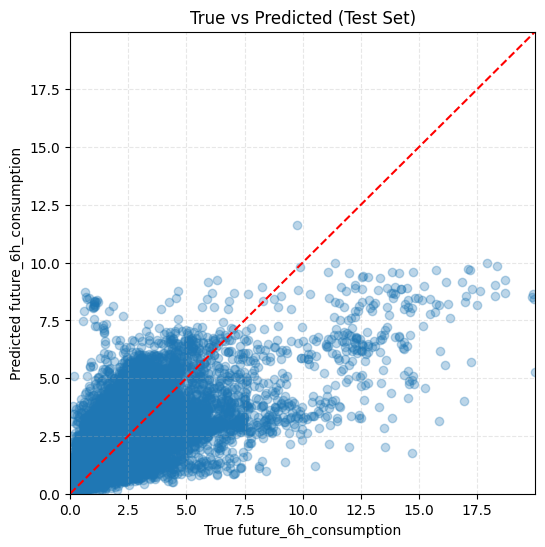


Top 20 important features:
                                    feature  importance
18                        w1_total_room_acs    0.297659
28                     avg_5d_same_time_kwh    0.206676
25                 backward_avg_consumption    0.168961
13                             w1_num_rooms    0.051015
22                                     hour    0.045819
29                     avg_1d_same_time_kwh    0.023916
30                     avg_1w_same_time_kwh    0.022208
26                   consumption_per_member    0.021453
24                                    month    0.018589
27                              fan_density    0.009909
23                                dayofweek    0.008287
9                             w1_num_lights    0.008078
4                      w1_hh_avg_hours_home    0.007740
21  total_monthly_expenditure_of_last_month    0.007394
8                        w1_fan_hours_night    0.007368
1                             w1_hh_avg_age    0.006851
20                  

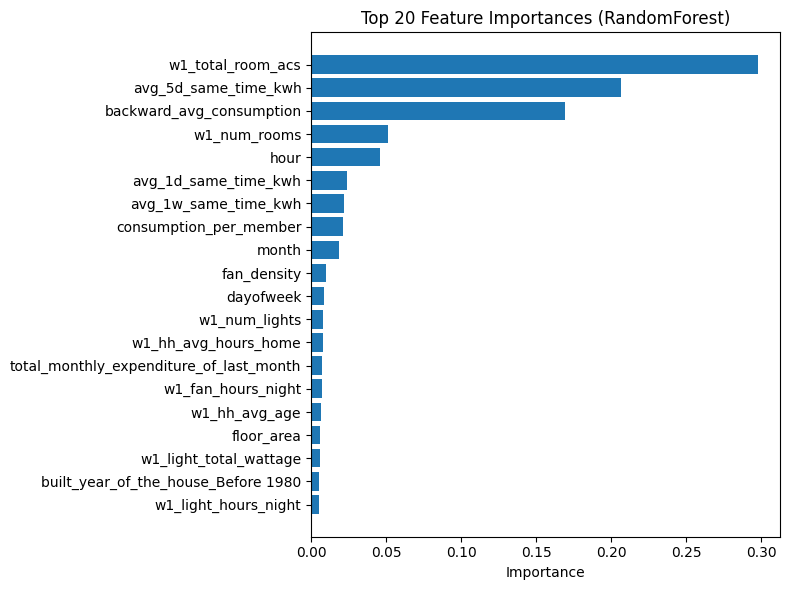

In [6]:
# ============================================
# 0. Basic setup
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline

# ============================================
# 1. Paths & Load data
# ============================================

from google.colab import drive
drive.mount('/content/drive')
TRAIN_PATH = Path("/content/drive/MyDrive/datasets/Train_set.csv")
TEST_PATH  = Path("/content/drive/MyDrive/datasets/Test_set.csv")

print("Train path:", TRAIN_PATH)
print("Test  path:", TEST_PATH)

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print("Columns sample:", train_df.columns[:15].tolist())

# ============================================
# 2. Define target, drop columns, feature columns
# ============================================

target_col = "future_6h_consumption"
if target_col not in train_df.columns:
    raise KeyError(f"Target column '{target_col}' not found in train_df")

drop_cols = [
    "household_ID",
    "DATE",
    "TIME",
    "timestamp",
]

USE_TOTAL_IMPORT_AS_FEATURE = False
if not USE_TOTAL_IMPORT_AS_FEATURE and "TOTAL_IMPORT (kWh)" in train_df.columns:
    drop_cols.append("TOTAL_IMPORT (kWh)")

leakage_like_cols = [
    "next_timestamp",
    "next_import",
    "delta_hours_next",
    "prev_import",
    "consumption_kwh",
]
for c in leakage_like_cols:
    if c in train_df.columns:
        drop_cols.append(c)

drop_cols = [c for c in drop_cols if c in train_df.columns]

print("Columns to drop (not used as features):")
print(drop_cols)

feature_cols = [c for c in train_df.columns if c not in drop_cols + [target_col]]
print("\nNumber of feature columns:", len(feature_cols))

# ============================================
# 3. Split numeric / categorical features
# ============================================

num_cols_all = train_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = train_df[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

print("\nInitial numeric cols (by dtype):", len(num_cols_all))
print("Initial categorical cols (by dtype):", len(cat_cols_all))

known_categorical_cols = [
    "own_the_house_or_living_on_rent",
    "type_of_house",
    "is_there_business_carried_out_in_the_household",
    "socio_economic_class",
    "method_of_receiving_water",
    "water_heating_method_for_bathing",
    "boil_water_before_drinking",
    "gas_used_for_cooking",
    "electricity_from_national_grid_used_for_cooking",
    "electricity_generated_using_solar_energy_used_for_cooking",
    "firewood_used_for_cooking",
    "kerosene_used_for_cooking",
    "sawdust_or_paddy_husk_used_for_cooking",
    "biogas_used_for_cooking",
    "coconut_shells_or_charcoal_used_for_cooking",
]

known_categorical_cols = [c for c in known_categorical_cols if c in feature_cols]

cat_cols = sorted(list(set(cat_cols_all).union(set(known_categorical_cols))))
num_cols = [c for c in feature_cols if c not in cat_cols]

print("\nFinal numeric feature columns ({}):".format(len(num_cols)))
print(num_cols)
print("\nFinal categorical feature columns ({}):".format(len(cat_cols)))
print(cat_cols)

# ============================================
# 4. Build preprocessing + model pipeline
# ============================================

numeric_transformer = "passthrough"

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore"
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# rf_model = RandomForestRegressor(
#     n_estimators=50,
#     max_depth=15,
#     min_samples_split=5,
#     min_samples_leaf=3,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
# )
# rf_model = RandomForestRegressor(
#     n_estimators=50,
#     max_depth=20,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
# )
# rf_model = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=30,
#     min_samples_split=5,
#     min_samples_leaf=2,
#     random_state=42,
#     n_jobs=-1,
#     verbose=1,
# )
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)
reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", rf_model),
    ]
)

# ============================================
# 5. Prepare X_train, y_train, X_test, y_test
# ============================================

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()

print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test  shape:", X_test.shape)
print("y_test  shape:", y_test.shape)

# ============================================
# 6. Train model
# ============================================

print("\nTraining RandomForestRegressor...")
reg_pipeline.fit(X_train, y_train)
print("Training done.")

# ============================================
# 7. Evaluate on test set
# ============================================

y_pred = reg_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Test Performance ===")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 : {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True future_6h_consumption")
plt.ylabel("Predicted future_6h_consumption")
plt.title("True vs Predicted (Test Set)")
lims = [0, max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# ============================================
# 8. Feature importance
# ============================================

def get_feature_names_from_column_transformer(ct):

    output_features = []

    for name, transformer, cols in ct.transformers_:
        if name == "num":
            output_features.extend(cols)
        elif name == "cat":
            ohe = transformer
            if hasattr(ohe, "get_feature_names_out"):
                ohe_feature_names = ohe.get_feature_names_out(cols)
            else:
                ohe_feature_names = ohe.get_feature_names(cols)
            output_features.extend(ohe_feature_names.tolist())
        else:
            continue

    return output_features

trained_rf = reg_pipeline.named_steps["model"]
trained_ct = reg_pipeline.named_steps["preprocess"]

feature_names = get_feature_names_from_column_transformer(trained_ct)
importances = trained_rf.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 20 important features:")
print(fi_df.head(20))

top_k = 20
plt.figure(figsize=(8, 6))
plt.barh(fi_df["feature"][:top_k][::-1], fi_df["importance"][:top_k][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

errors_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred
})

errors_df["abs_error"] = (errors_df["y_true"] - errors_df["y_pred"]).abs()
errors_df["squared_error"] = (errors_df["y_true"] - errors_df["y_pred"]) ** 2

errors_df["percentage_error"] = np.where(
    errors_df["y_true"] != 0,
    errors_df["abs_error"] / errors_df["y_true"] * 100.0,
    np.nan
)

errors_df_sorted = errors_df.sort_values("abs_error", ascending=False)

OUTPUT_CSV_PATH = "/content/drive/MyDrive/datasets/rf_test_errors.csv"
errors_df_sorted.to_csv(OUTPUT_CSV_PATH, index=False)
print("Saved per-sample errors to:", OUTPUT_CSV_PATH)

Saved per-sample errors to: /content/drive/MyDrive/datasets/rf_test_errors.csv
